In [2]:
"""
Evaluation scripts for the PyBirales paper.
Notebook reproduces the figures used in the paper.

"""
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 10)

sns.set_style("ticks")

In [5]:
# 1. Average timings per module

# LOG_DIR = '/var/log/birales'
LOG_DIR = '/home/denis/Documents/PhD/birales/2018'
log_files = []
for subdir, dirs, files in os.walk(LOG_DIR):
    for log_file in files:
        log_files.append(os.path.join(subdir, log_file))


def profile_modules(log_files, modules, skip=['Detector']):
    profiling = []    
    processed_logfiles = 0
    for log_file_path in log_files:
        lines = []
        profiling_modules = []
        with open(log_file_path, 'r') as f:
           log_lines = f.readlines()

        # Iterate each line
        level = 'INFO'
        pattern = 'in [-+]?([0-9]*\.[0-9]+|[0-9]+) s'

        for i, line in enumerate(log_lines):
            split_line = line.split()
            
            match = re.search(pattern, line)
            time_taken = 0
            found = 0
            if match:
                module_name = split_line[5]
                time_taken = float(match.group().split()[1])
                # Skip log_files which contain the detector
                if module_name in skip:
                    break
                    
            match_detections = re.search('Found [-+]?([0-9]*\.[0-9]+|[0-9]+) new candidates', line)
            if match_detections:
                module_name = split_line[5]
                found = int(match_detections.group().split()[1])
            
            if match or match_detections:
                if module_name in modules:
                    profiling_modules.append({'Module': module_name, 'Processing Time': time_taken, 'Candidates Found': found})  
                
        else:
            profiling += profiling_modules
            
        processed_logfiles += 1
    print 'Processed %s / %s log files' % (processed_logfiles, len(log_files))
    
    return  pd.DataFrame(profiling)


Processed 190 / 190 log files


,Candidates Found,Processing Time
Module,,
Beamformer,0.000000,0.105975
Channeliser,0.000000,0.988692
CorrMatrixPersister,0.000000,0.018522
Correlator,0.000000,0.427685
Detector,1.312621,0.107282
Filtering,0.000000,0.424341
PreProcessor,0.000000,0.545977


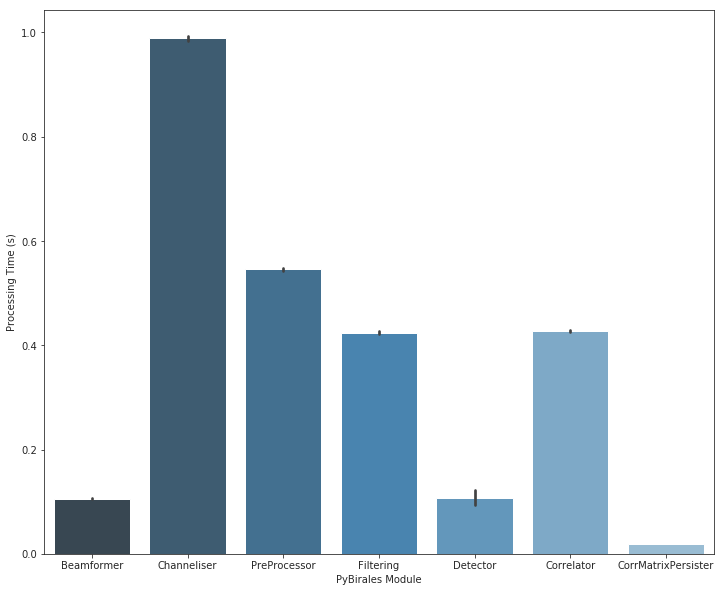

In [7]:
# 1.1 Average timings per module - PyBirales Modules
modules = ['Filtering',  'Correlator','PreProcessor','Channeliser','Beamformer',
           'Detector', 'Receiver', 'RawDataReader', 'Dummy-8','RawDataReader',
           'RawPersister','CorrMatrixPersister','FilteredFitsPersister','RawFitsPersister']

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']
p_df = profile_modules(log_files, modules, skip=skip)
ax = sns.barplot(x="Module", y="Processing Time", data=p_df, palette="Blues_d")
ax.set(xlabel='PyBirales Module', ylabel='Processing Time (s)')
# ax.axhline(y=3.34)
p_df.groupby('Module').mean()

Processed 152 / 190 log files (Skipped 38)


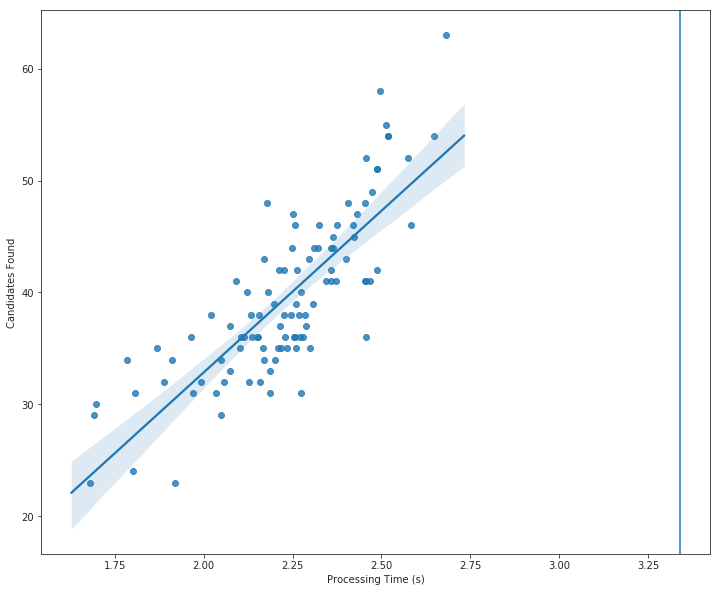

In [8]:
# 2. Total time for a detection
# 1.1 Average timings per module - PyBirales Modules


# 1. Average timings per module

def profile_detector(log_files, skip=[]):
    profiling = []    
    processed_logfiles = 0
#     log_files = ['/home/denis/Documents/PhD/birales/2018/2018_12_08/D1.log']
    for log_file_path in log_files:
        lines = []
        profiling_modules = []
        with open(log_file_path, 'r') as f:
            log_lines = f.readlines()

        # Iterate each line        
        found = 0
        time_taken = 0
        for i, line in enumerate(log_lines):
            split_line = line.split()
                
            match_detections = re.search('Found [-+]?([0-9]*\.[0-9]+|[0-9]+) new candidates', line)
            if match_detections:
                found = int(match_detections.group().split()[1])
                continue
                        
            match = re.search('in [-+]?([0-9]*\.[0-9]+|[0-9]+) s', line)
            if match:
                module_name = split_line[5]
                
                if module_name == 'Detector':
                    time_taken = float(match.group().split()[1])

                    if time_taken > 0.:
                        profiling_modules.append({'Module': 'Detector', 'Processing Time': time_taken, 'Candidates Found': found})  
                    
                    if time_taken > 2 and found == 0:
                        print log_file_path, i
                    time_taken = 0
                    found=0
                elif module_name in skip:
                    break        
        else:
            profiling += profiling_modules
            processed_logfiles += 1
    
        
        
    print 'Processed %s / %s log files (Skipped %s)' % (processed_logfiles, len(log_files), len(log_files)-processed_logfiles)
    
    return  pd.DataFrame(profiling)

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']
pd_df = profile_detector(log_files, skip)
pd_df = pd_df[pd_df['Candidates Found']  > 10]
ax = sns.regplot(x=pd_df['Processing Time'], y=pd_df['Candidates Found'])
ax.set(xlabel='Processing Time (s)', ylabel='Candidates Found')
ax.axvline(x=3.34)



Processed 1 / 1 log files
Processed 1 / 1 log files
Processed 1 / 1 log files
Processed 1 / 1 log files
        Module  Candidates Found  Processing Time Scaling factor
0   Beamformer                 0         0.030471           x0.5
1  Channeliser                 0         0.398780           x0.5
0   Beamformer                 0         0.092439             x1
1  Channeliser                 0         0.789152             x1
0   Beamformer                 0         0.327240             x2


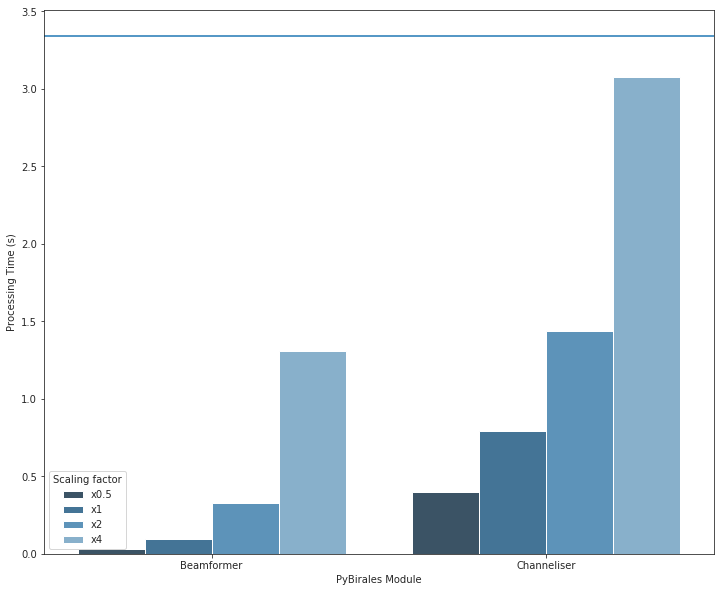

In [25]:
# 3. Scaling to 64 antennas

scaling_dir = '/var/log/birales/2019_02_15'
log_files_scaling = [
    (os.path.join(scaling_dir, 'DUMMY16.log'), 'x0.5'),
    (os.path.join(scaling_dir, 'DUMMY32.log'), 'x1'),
    (os.path.join(scaling_dir, 'DUMMY64.log'), 'x2'),
    (os.path.join(scaling_dir, 'DUMMY128.log'), 'x4')
]

skip=['RawPersister', 'FilteredFitsPersister','RawFitsPersister']

frames = []
for i in range(0, 4):
    log_file = log_files_scaling[i]
    df = profile_modules([log_file[0]], modules, skip=skip)  
    
    df =   df.groupby('Module', as_index=False).mean()
    df['Scaling factor'] = log_file[1]
    
    frames.append(df)
    
ps_df = pd.concat(frames)
print ps_df.head()
ax = sns.barplot(x="Module", y="Processing Time", data=ps_df, ci='sd', hue='Scaling factor',palette="Blues_d")
ax.set(xlabel='PyBirales Module', ylabel='Processing Time (s)')
ax.axhline(y=3.34)



In [ ]:
# 4. Plot casa passing through the 32 beams

In [ ]:
# 5. Multi-pixel map with beams lit-on (showing trajectory)